$\large\textbf{On the Virasoro fusion and modular kernels at any irrational value
of the central charge}$

This notebook contains numerical verifications of the main claims of the article with the same name, by Julien Roussillon.

In [2]:
import sys
'''We need a code from Sylvain Ribault in https://gitlab.com/s.g.ribault/Bootstrap_Virasoro
which implements the double gamma function.'''
sys.path.append('/Users/julien/Desktop/Bootstrap_Virasoro')
from Auxiliary_classes import log_double_Gamma

from mpmath import mp, pi, sin, sinh, cosh, exp

'''Below we implement the series f in (1.15).'''

class series:
    
    def __init__(self, b = mp.mpc('0.77','0'), moms = [mp.mpc('0','0.4'),mp.mpc('0','0.3'),mp.mpc('0','0.7'),mp.mpc('0','0.5')], 
                 Ps = mp.mpc('0','0.25'), Pt = mp.mpc('0','0.2'), order = 8, memo_phidiag = {}, memo_alpha = {},memo_phi_ln = {}):

        self.b = b
        self.moms = moms
        self.Ps = Ps
        self.Pt = Pt
        self.order = order
        self.memo_phidiag = memo_phidiag
        self.memo_alpha = memo_alpha
        self.memo_phi_ln = memo_phi_ln
    
    def phidiag(self,b,P1,P2,P3,P4,n):

        """
        For the methods phidiag, alpha and phi_ln we store the computations in a dictionary. 
        This greatly improves the computation time of the coefficients.
        """
        
        key = (b,P1,P2,P3,P4,n)
    
        if key in self.memo_phidiag:
            return self.memo_phidiag[key]      

        Ps = [P1+P2, -P1+P2, P3+P4, P3-P4]
        numerator = 1j * 2**(2*n-1) * (-1)**(n+1)
        denominator = sin(n*pi*b**2)
        
        for l in range(1, n+1):
            x = (b * 1j * (2*l-n-1)) / 2
            for P in Ps: numerator *= cosh(pi*b*(P+x)) 
        for l in range(1, n):
            denominator *= sin(l * pi * b**2)**2
        result = numerator / denominator
        self.memo_phidiag[key] = result
        return result
        
    
    def alpha(self,b,P1,P2,P3,P4,Ps,n):
       
        key = (b,P1,P2,P3,P4,Ps,n)
    
        if key in self.memo_alpha:
            return self.memo_alpha[key]
            
        if n == 0:
            return 1  
        else:
            sum_term = 0
            for l in range(1, n + 1):
                term1 = exp(- pi * b * (Ps + (l*1j*b)/2))
                sum_term += term1 * (self.phi_ln(b,P1,P2,P3,P4,l,n) / sinh(pi*b*(Ps+(l*1j*b)/2)) 
                          - self.phi_ln(b,P1,P2+1j/(2*b),P3+1j/(2*b),P4,l,n) / cosh(pi*b*(Ps+(l*1j*b)/2)))
            self.memo_alpha[key] = sum_term
            return sum_term

    def phi_ln(self,b,P1,P2,P3,P4,l,n):
       
        key = (b,P1,P2,P3,P4,l,n)
    
        if key in self.memo_phi_ln:
            return self.memo_phi_ln[key]
            
        result = self.phidiag(b,P1,P2,P3,P4,l) * self.alpha(b,P1,P2,P3,P4,l*1j*b/2,n - l)
        self.memo_phi_ln[key] = result
        return result
        

    def f(self):

        (P1,P2,P3,P4) = tuple(self.moms)
        b = self.b
        Ps = self.Ps
        Pt = self.Pt
        order = self.order

        sum_term_1 = 1
        sum_term_2 = 1
        
        for k in range(1,order+1):
           sum_term_1 += self.alpha(b,P1,P2,P3,P4,Ps,k) * exp(-2*pi*b*k*Pt)
        for l in range(1,order+1):
           sum_term_2 += self.alpha(1/b,P1,P2,P3,P4,Ps,l) * exp(-2*pi*l*Pt/b)

        return exp(2*1j*pi*Ps*Pt) * sum_term_1 * sum_term_2
    

    """
    Class implementing the Virasoro fusion kernel for c<=1.
    """

class fusionkernelhat:
    
    def __init__(self, beta = mp.mpc('0.77','0'), moms = [mp.mpc('0','0.4'),mp.mpc('0','0.3'),mp.mpc('0','0.7'),mp.mpc('0','0.5')],
                 ps = mp.mpc('0','0.25'), pt = mp.mpc('0.2','0.5'), order = 8):

        self.beta = beta
        self.Qhat = beta+1/beta
        self.moms = moms
        self.ps = ps
        self.pt = pt
        self.order = order
    
    def Khat(self):

        beta = self.beta
        Qhat = self.Qhat
        (p1,p2,p3,p4) = tuple(self.moms)
        pt = self.pt
        ps = self.ps
        ldg = log_double_Gamma(beta).val
        
        result = ldg(2*1j*pt+1/beta) + ldg(2*1j*pt+beta)
        result -= ldg(-2*1j*ps+1/beta) + ldg(-2*1j*ps+beta)
        
        for i in (-1,1):
            for j in (-1,1):
                result += ldg(Qhat/2-1j*ps+i*1j*p2+j*1j*p1) + ldg(Qhat/2-1j*ps+i*1j*p3+j*1j*p4)
                result -= ldg(Qhat/2+1j*pt+i*1j*p2+j*1j*p3) + ldg(Qhat/2+1j*pt+i*1j*p1+j*1j*p4)
        
        result += 1j * pi * (p1**2+p2**2+p3**2+p4**2+(1+beta**2+beta**(-2))/4)
        
        return -1j*exp(result)

    """
    Implementation of the whole kernel at once.
    """

    def Fhat(self):
        
        beta = self.beta
        moms = self.moms
        ps = self.ps
        pt = self.pt
        order = self.order
        splus = series(beta,moms,ps,pt,order)
        sminus = series(beta,moms,-ps,pt,order)
        Khatplus = self.Khat()
        self.ps = - self.ps
        Khatminus = self.Khat()
        
        return 0.5 * (Khatplus * splus.f() + Khatminus * sminus.f())
    
    """
    For numerical test of the fusion transformation, it is convenient 
    to separate the parts of Khat which depend on Ps and Pt. 
    The parts which depend on Ps can be taken out of the integral.
    """
    
    def Khat_pt_part(self):
        
        beta = self.beta
        Qhat = self.Qhat
        (p1,p2,p3,p4) = tuple(self.moms)
        pt = self.pt
        
        ldg = log_double_Gamma(beta).val
        
        result = ldg(2*1j*pt+1/beta) + ldg(2*1j*pt+beta) 
        
        for i in (-1,1):
            for j in (-1,1):
                result -= ldg(Qhat/2+1j*pt+i*1j*p2+j*1j*p3) + ldg(Qhat/2+1j*pt+i*1j*p1+j*1j*p4)
        
        return exp(result)

    def Khat_ps_part(self):

        beta = self.beta
        Qhat = self.Qhat
        (p1,p2,p3,p4) = tuple(self.moms)
        ps = self.ps

        ldg = log_double_Gamma(beta).val        
        result = - ldg(-2*1j*ps+1/beta) - ldg(-2*1j*ps+beta)
        
        for i in (-1,1):
            for j in (-1,1):
                result += ldg(Qhat/2-1j*ps+i*1j*p2+j*1j*p1) + ldg(Qhat/2-1j*ps+i*1j*p3+j*1j*p4)
        
        result += 1j * pi * (p1**2+p2**2+p3**2+p4**2+(1+beta**2+beta**(-2))/4)
        
        return -1j * exp(result)

    def Fhatplus_pt_part(self):
        
        beta = self.beta
        moms = self.moms
        ps = self.ps
        pt = self.pt
        order = self.order
        return self.Khat_pt_part() * series(beta,moms,ps,pt,order).f() 

'''We will need a code from Sylvain Ribault in https://gitlab.com/s.g.ribault/Bootstrap_Virasoro
which implements the conformal blocks.'''

from CFT import *
from Blocks import Block
import numpy as np
from scipy.integrate import quad

class fusion:

    def __init__(self, beta = mp.mpc('0.77','0'), moms = [mp.mpc('0','0.4'),mp.mpc('0','0.3'),mp.mpc('0','0.7'),mp.mpc('0','0.5')], 
                 ps = mp.mpc('0','0.25'), orderseries = 10, Nmax = 12, L = 4, Lambda = mp.mpf('0.5'), z = mp.mpc('0.5','0'),
                 epsabs = 1e-8, epsrel = 1e-8):

        self.beta = beta
        self.moms = moms
        self.ps = ps
        self.orderseries = orderseries
        self.Nmax = Nmax
        self.L = L
        self.Lambda = Lambda
        self.z = z
        self.epsabs = epsabs
        self.epsrel = epsrel
        
        self.charge = Charge('beta', self.beta)
        c = self.charge.get('c')
        
        '''Note that Ribault uses the convention \Delta(P) = Q^2/4 - P^2 or \Delta(P) = Q^2/4 + p^2,
        whereas we use the convention \Delta(P) = Q^2/4 + P^2 or \Delta(P) = Q^2/4 - p^2.'''
        
        self.Di = [Dimension('P', momsi, self.charge) for momsi in self.moms]
        self.Ds = Dimension('P', self.ps, self.charge)
        self.sblock = Block(self.Di, Nmax = Nmax)
        self.tblock = Block(self.Di, Nmax = Nmax, channel = 't')


    def integrand_function(self, ps, pt, imag=False):

        beta = self.beta
        moms = self.moms
        orderseries = self.orderseries
        Di = self.Di
        charge = self.charge
        Lambda = self.Lambda
        z = self.z
        
        tblock_value = self.tblock.value(position = z)(Dimension('P', 1j * pt + Lambda, charge))
        kernel = fusionkernelhat(beta, moms, ps, 1j * pt + Lambda, orderseries)
        func_value = kernel.Fhatplus_pt_part() * tblock_value
        return float(np.imag(func_value)) if imag else float(np.real(func_value))

    def integrate_function(self, ps, imag=False):

        L = self.L
        func = lambda pt: self.integrand_function(ps, pt, imag)
        return quad(func, -L, L, epsabs = self.epsabs, epsrel = self.epsrel)[0]


    def result_integral(self):

        beta = self.beta
        moms = self.moms
        ps = self.ps
        orderseries = self.orderseries
        
        integrals = {}
        for sign in [mp.mpf('-1'), mp.mpf('1')]:
            integrals[(sign, 'real')] = self.integrate_function(sign * ps, imag=False)
            integrals[(sign, 'imag')] = self.integrate_function(sign * ps, imag=True)

        result = mp.mpf('0.5') * sum(fusionkernelhat(beta, moms, ps = sign * ps, order = orderseries).Khat_ps_part() *
        (integrals[(sign, 'real')] + 1j * integrals[(sign, 'imag')]) for sign in [mp.mpf('-1'), mp.mpf('1')])
        
        return result

    def sblockvalue(self):
        return self.sblock.value(position = self.z)(self.Ds)

In [17]:
'''Testing the fusion transformation for c \leq 1.'''

mp.dps = 20

orderseries = [0, 1, 2, 3, 4, 6, 8]
Nmax = [10, 12, 14, 16, 18, 20, 22]
L = [1, 2, 3, 4, 5, 6, 8]
epsabs = [1e-8, 1e-8, 1e-8, 1e-9, 1e-9, 1e-10, 1e-10]
epsrel = [1e-8, 1e-8, 1e-8, 1e-9, 1e-9, 1e-10, 1e-10]

for ord, nmax, LL, epsa, epsr in zip(orderseries, Nmax, L, epsabs, epsrel):
    sblock = fusion(Nmax = nmax).sblockvalue()
    #print(f"block value at position z: {sblock}")
    integral = fusion(orderseries = ord, Nmax = nmax, L = LL, epsabs = epsa, epsrel = epsr).result_integral()
    #print(f"result of the integration: {integral}")
    print(f"Absolute value of the difference between sblock and integral: {abs(sblock-integral)}")

Absolute value of the difference between sblock and integral: 0.17466350995246453392
Absolute value of the difference between sblock and integral: 0.056452652975402134008
Absolute value of the difference between sblock and integral: 0.000012836663140537724443
Absolute value of the difference between sblock and integral: 2.6811525325348017098e-9
Absolute value of the difference between sblock and integral: 2.29413593582981538e-15
Absolute value of the difference between sblock and integral: 6.0986026904030394393e-15
Absolute value of the difference between sblock and integral: 4.8262795714007344851e-15


In [18]:
'''Testing the fusion transformation for c \leq 1 for other parameters.'''

beta = mp.mpc('0.6','0')
moms = [mp.mpc('0','0.4'),mp.mpc('0','0.6'),mp.mpc('0','0.3'),mp.mpc('0','0.5')]
ps = mp.mpc('0','0.35')

mp.dps = 20

orderseries = [0, 1, 2, 3, 4, 6, 8]
Nmax = [10, 12, 14, 16, 18, 20, 25]
L = [1, 2, 3, 4, 5, 6, 8]
epsabs = [1e-8, 1e-8, 1e-8, 1e-9, 1e-9, 1e-10, 1e-10]
epsrel = [1e-8, 1e-8, 1e-8, 1e-9, 1e-9, 1e-10, 1e-10]

for ord, nmax, LL, epsa, epsr in zip(orderseries, Nmax, L, epsabs, epsrel):
    sblock = fusion(beta, moms, ps, Nmax = nmax).sblockvalue()
    integral = fusion(beta, moms, ps, orderseries = ord, Nmax = nmax, L = LL, epsabs = epsa, epsrel = epsr).result_integral()
    print(f"Absolute value of the difference between sblock and integral: {abs(sblock-integral)}")

Absolute value of the difference between sblock and integral: 1.2070068934325008777
Absolute value of the difference between sblock and integral: 0.25912661110190264424
Absolute value of the difference between sblock and integral: 0.011794233959982179025
Absolute value of the difference between sblock and integral: 0.000014651226373326199075
Absolute value of the difference between sblock and integral: 8.5949254521259595776e-10
Absolute value of the difference between sblock and integral: 8.5735481899948834264e-16
Absolute value of the difference between sblock and integral: 3.2465720520702331111e-16


(1.0802877854515778-1.5814985688321277e-07j)
(1.0802868398445404651 + 0.0j)
(9.4560703731050269765e-7 - 1.581498568832127722e-7j)


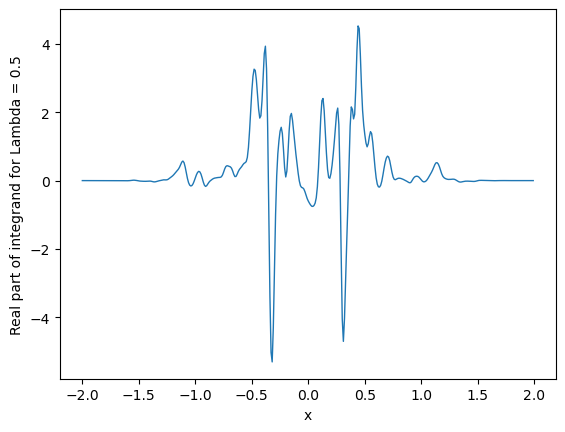

(1.080310060410168-1.8275060777445523e-06j)
(1.0802868398445404651 + 0.0j)
(0.000023220565627617539541 - 1.8275060777445523311e-6j)


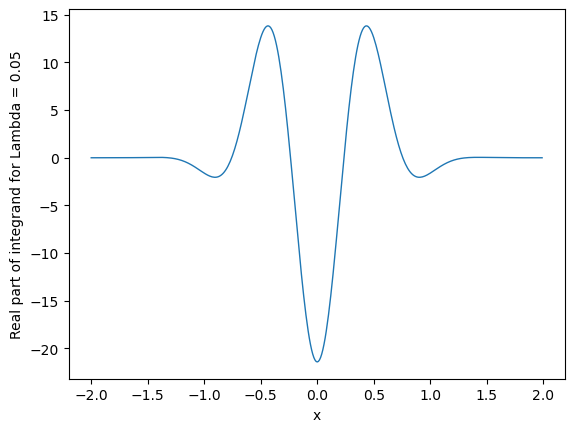

In [5]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

beta = mp.mpc('0.6','0')
moms = [mp.mpc('0','0.4'),mp.mpc('0','0.6'),mp.mpc('0','0.3'),mp.mpc('0','0.5')]
ps = mp.mpc('0','0.35')
order = 8
z = mp.mpf('0.5')

mp.dps = 20

charge = Charge('beta', beta)
Di = [Dimension('P', momsi, charge) for momsi in moms]
Ds = Dimension('P', ps, charge)
c = charge.get('c')

blockt = Block(Di, Nmax = 20, channel = 't')
blocks = Block(Di, Nmax = 20)

ptvals = np.arange(-2,2,0.01) 

data_points = np.array([[pt,float(np.real(fusionkernelhat(beta,moms,ps,1j*pt+Lambda,order).Fhat()*blockt.value(position = z)(Dimension('P', 1j*pt+Lambda, charge))))
                         + 1j*float(np.imag(fusionkernelhat(beta,moms,ps,1j*pt+Lambda,order).Fhat()*blockt.value(position = z)(Dimension('P', 1j*pt+Lambda, charge))))] for pt in ptvals])

xs = data_points[:, 0].real
ys = data_points[:, 1]
spl = CubicSpline(xs, ys)

print(spl.integrate(xs[0], xs[-1]))
print(blocks.value(position = z)(Ds))
print(spl.integrate(xs[0], xs[-1]) - blocks.value(position = z)(Ds))

plt.plot(xs, ys.real, linewidth=1)
plt.xlabel("x")
plt.ylabel("Real part of integrand for Lambda = 0.5")
plt.show()

Lambda = 0.5

data_points = np.array([[pt,float(np.real(fusionkernelhat(beta,moms,ps,1j*pt+Lambda,order).Fhat()*blockt.value(position = z)(Dimension('P', 1j*pt+Lambda, charge))))
                         + 1j*float(np.imag(fusionkernelhat(beta,moms,ps,1j*pt+Lambda,order).Fhat()*blockt.value(position = z)(Dimension('P', 1j*pt+Lambda, charge))))] for pt in ptvals])

xs = data_points[:, 0].real
ys = data_points[:, 1]
spl = CubicSpline(xs, ys)

print(spl.integrate(xs[0], xs[-1]))
print(blocks.value(position = z)(Ds))
print(spl.integrate(xs[0], xs[-1]) - blocks.value(position = z)(Ds))

plt.plot(xs, ys.real, linewidth=1)
plt.xlabel("x")
plt.ylabel("Real part of integrand for Lambda = 0.05")
plt.show()

In [19]:
class fusionkernel:

    """ 
    In this class we implement the series representation for the fusion kernel at c>=25 which 
    is equivalent to Ponsot-Teschner's formula.
    """
    
    def __init__(self, b=0.7, moms=[0.4,0.6,0.3,0.2], Ps=0.127*1j, Pt=0.2*1j+0.5, order=6):

        self.b = b
        self.Q = b+1/b
        self.Ps = Ps
        self.Pt = Pt
        self.order = order
        self.moms = moms

    def K(self):

        b=self.b
        Q = self.Q
        (P1,P2,P3,P4) = tuple(self.moms)
        Ps = self.Ps
        Pt = self.Pt
        
        ldg = log_double_Gamma(b).val
        
        result = ldg(2*1j*Ps) + ldg(Q+2*1j*Ps)
        result -= ldg(-2*1j*Pt) + ldg(Q-2*1j*Pt)
        
        for i in (-1,1):
            for j in (-1,1):
                result += ldg(Q/2-1j*Pt+i*1j*P2+j*1j*P3) + ldg(Q/2-1j*Pt+i*1j*P1+j*1j*P4)
                result -= ldg(Q/2+1j*Ps+i*1j*P2+j*1j*P1) + ldg(Q/2+1j*Ps+i*1j*P3+j*1j*P4)
        result += 1j * pi * (P1**2+P2**2+P3**2+P4**2+(1+b**2+b**(-2))/4)
        
        return exp(result)

    def Fplus(self):
        
        b = self.b
        (P1,P2,P3,P4) = tuple(self.moms)
        Pt = self.Pt
        Ps = self.Ps
        order = self.order
        s = series(b,[P1,P2,P3,P4],Ps,Pt,order)
        
        return self.K() * s.f()
    
    def F(self):
        
        b=self.b
        (P1,P2,P3,P4) = tuple(self.moms)
        Pt = self.Pt
        Ps = self.Ps
        order = self.order
        splus = series(b,[P1,P2,P3,P4],Ps,Pt,order)
        sminus = series(b,[P1,P2,P3,P4],-Ps,Pt,order)
        Kplus = self.K()
        self.Ps = -self.Ps
        Kminus = self.K()
        
        return 0.5 * (Kplus * splus.f() + Kminus * sminus.f())

"""
Below we implement the Ponsot-Teschner formula for the fusion kernel at c>=25.
"""

from scipy.integrate import quad  
    
    
class Ponsot_Teschner:
    
    def __init__(self, b = mp.mpf('.4'), 
                 moms = [1j*mp.mpf('.3'), 1j*mp.mpf('.2'), 1j*mp.mpf('.5'), 1j*mp.mpf('.7')],
                 Ps = 1j*mp.mpf('.4'), Pt = mp.mpc('0', '.81')):
        
        self.b = b
        self.Q = b+1/b
        self.moms = moms
        self.Ps = Ps
        self.Pt = Pt
        
    
    def prefactor(self):
        
        b = self.b
        Q = self.Q
        (P1, P2, P3, P4) = tuple(self.moms)
        (Ps, Pt) = (self.Ps, self.Pt)
        ldg = log_double_Gamma(b).val 
        
        result = 0
        
        for i in (-1,1):
            result += ldg(Q+2*i*1j*Ps) - ldg(2*i*1j*Pt)
            for j in (-1,1):
                result += ldg(Q/2-1j*P2+i*1j*P3+j*1j*Pt)
                result += ldg(Q/2+1j*P4+i*1j*P1+j*1j*Pt)
                result -= ldg(Q/2-1j*P2+i*1j*P1+j*1j*Ps)
                result -= ldg(Q/2+1j*P4+i*1j*P3+j*1j*Ps)
            
        return exp(result)
    
    def logSb(self,x): 
        
        b = self.b
        ldg = log_double_Gamma(b).val 
        return ldg(x)-ldg(b+1/b-x)
    
    def integrand(self,u):
        
        b = self.b
        Q = self.Q
        (P1, P2, P3, P4) = tuple(self.moms)
        (Ps, Pt) = (self.Ps, self.Pt)
        
        result = 0
        for i in (-1,1):
            result += self.logSb(Q/4-1j*P2+i*1j*P1+u) + self.logSb(Q/4+1j*P4+i*1j*P3+u)
            result -= self.logSb(3*Q/4-1j*P2+1j*P4+i*1j*Pt+u) + self.logSb(3*Q/4+i*1j*Ps+u)
        
        return exp(result)
    
        
    def integrand_function(self, u, imag=False):
        
        func_value = self.integrand(1j * u) 
            
        return np.imag(func_value) if imag else np.real(func_value)
    
    
    def integrate_function(self, imag=False):
        
        func = lambda u: self.integrand_function(u, imag)
        
        return quad(func, -8, 8, epsabs = 1e-8, epsrel = 1e-8, limit = 50)


    def result_integral(self):
        
        integrals_real = self.integrate_function(imag=False)
        integrals_imag = self.integrate_function(imag=True)

        result = 0.5 * integrals_real[0] + 1j * integrals_imag[0]

        return self.prefactor() * result

In [20]:
'''Comparing our proposal with the Ponsot-Teschner formula.'''

mp.dps = 20

b = mp.mpc('0.77','0')
moms = [mp.mpc('0','0.5'),mp.mpc('0','0.6'),mp.mpc('0','0.18'),mp.mpc('0','0.31')]
Ps = mp.mpf('0.35') 
Pt = mp.mpf('0.65')
(P1,P2,P3,P4) = tuple(moms)
Q = b+1/b

PT = Ponsot_Teschner(b, moms, Ps, Pt)
PonsotTeschner = PT.result_integral()
print("Result from Ponsot-Teschner:", PonsotTeschner)

for i in range (0,13):
    FusionKernel = fusionkernel(b,moms,Ps,Pt,order = i).F()
    #print(FusionKernel)
    print("Absolute value of the difference:", abs(PonsotTeschner - FusionKernel))

Result from Ponsot-Teschner: (0.15411814567645135493 + 2.6108629431538439273e-22j)
Absolute value of the difference: 0.017298157139035646501
Absolute value of the difference: 0.00069421679615834185324
Absolute value of the difference: 0.000028338358307193741564
Absolute value of the difference: 2.9077034795304571957e-6
Absolute value of the difference: 1.4360350447629467352e-7
Absolute value of the difference: 8.2917397150172856155e-9
Absolute value of the difference: 3.0387099333448829371e-10
Absolute value of the difference: 1.5160050113724546911e-11
Absolute value of the difference: 8.4636930489616771462e-13
Absolute value of the difference: 2.6106158367929426315e-14
Absolute value of the difference: 1.7285257949958966382e-15
Absolute value of the difference: 4.5661055801005838662e-16
Absolute value of the difference: 4.4928873434957622046e-16


In [21]:
'''Verifying the duality formula (2.13).'''

mp.dps = 20
b = mp.mpc('.637','0')
moms = [mp.mpc('0.','0.4'),mp.mpc('0','0.5'),mp.mpc('0','0.7'),mp.mpc('0','0.2')]
momsexchange = [moms[2],moms[1],moms[0],moms[3]]
Ps = mp.mpc('.33','0.')
Pt = mp.mpc('0.6','0.')

for i in range(1,25):
    print(abs(series(b,moms,Ps,Pt,order = i).f() - series(b,momsexchange,Pt,Ps,order = i).f()))

0.007494595146157832369
0.00062351836211814483471
0.00037924988967691785658
0.000076228702773226871521
0.000024440254674468269903
3.309300838002331318e-6
1.3885078222681160233e-6
3.6512010562209485317e-7
1.3989858493546629078e-7
2.2946635194069573959e-8
6.6595289147274437235e-9
1.400985235992072007e-9
6.5899994097909634866e-10
1.4023063509502937711e-10
4.2890579291104424708e-11
5.946506189978572997e-12
2.6425206509902651542e-12
6.8744356495434179117e-13
2.5503434375386675952e-13
4.0202264590216496517e-14
1.1992484074967269713e-14
2.7095587630196344161e-15
1.2398785135621616072e-15
2.5390864142029426913e-16


In [22]:
"""Verifying Equation (2.12) up to k = 40."""

def V(Ps):
    sum_term = 0
    for k in [-1, 1]:
        prod_term = 1
        for epsilon in [-1, 1]:
            numerator = cosh(pi*b*(epsilon*P4-0.5j*b-P3-k*Ps))*cosh(pi*b*(epsilon*P1-0.5j*b-P2-k*Ps))
            prod_term *= numerator
        denominator = sinh(2*pi*b*(k*Ps+0.5j*b)) * sinh(2*np.pi*b*k*Ps)
        sum_term += prod_term / denominator
    
    return -2 * cosh(2*pi*b*(P2+P3+0.5j*b)) + 4*sum_term

def A(Ps):
    numerator = 16
    for i in (-1,1): 
        for j in (-1,1): 
            numerator *= cosh(pi*b*(Ps+i*P1+j*P2+0.5j*b)) * cosh(pi*b*(Ps+i*P3+j*P4+0.5j*b))
    denominator = sinh(2*pi*b*Ps) * sinh(2*pi*b*(Ps+0.5j*b))**2 * sinh(2*pi*b*(Ps+1j*b))
    return numerator / denominator

mp.dps = 20
b = mp.mpc('.77','0')
moms = [mp.mpc('0.','0.4'),mp.mpc('0','0.5'),mp.mpc('0','0.7'),mp.mpc('0','0.2')]
[P1, P2, P3, P4] = [moms[0], moms[1], moms[2], moms[3]]
Ps = mp.mpc('.33','0.')
Pt = mp.mpc('0.6','0.')

def recurrence(k):
    s = series(b,moms,Ps,Pt)
    akplus1shifted = s.alpha(b,moms[0],moms[1],moms[2],moms[3],Ps-1j*b,k+1)
    akminus1shifted = s.alpha(b,moms[0],moms[1],moms[2],moms[3],Ps+1j*b,k-1)
    ak = s.alpha(b,moms[0],moms[1],moms[2],moms[3],Ps,k)
    akminus1 = s.alpha(b,moms[0],moms[1],moms[2],moms[3],Ps,k-1)
    akplus1 = s.alpha(b,moms[0],moms[1],moms[2],moms[3],Ps,k+1)
    
    return akplus1shifted + akminus1shifted*A(Ps) + ak*V(Ps) - akminus1 - akplus1

for i in range(0,41):
    print(f"Equation (2.12) for i = {i}: {abs(recurrence(i))}")

Equation (2.12) for i = 0: 1.7556981293331917066e-17
Equation (2.12) for i = 1: 1.0788603620907508046e-18
Equation (2.12) for i = 2: 1.3225438302894693999e-18
Equation (2.12) for i = 3: 5.3987633750655570241e-19
Equation (2.12) for i = 4: 2.4428572970229443668e-18
Equation (2.12) for i = 5: 1.1917474851186844864e-18
Equation (2.12) for i = 6: 2.2679779821631481317e-18
Equation (2.12) for i = 7: 5.6461501976238845689e-19
Equation (2.12) for i = 8: 1.4315091784697811166e-18
Equation (2.12) for i = 9: 1.273460743413757285e-18
Equation (2.12) for i = 10: 3.0846467078612152645e-18
Equation (2.12) for i = 11: 7.4549291970282804622e-19
Equation (2.12) for i = 12: 1.2858822950206316501e-18
Equation (2.12) for i = 13: 1.0001614401263917835e-18
Equation (2.12) for i = 14: 3.3774118264900937061e-18
Equation (2.12) for i = 15: 3.0569852451885547089e-18
Equation (2.12) for i = 16: 2.8918581593190317225e-18
Equation (2.12) for i = 17: 7.0912109355969576991e-19
Equation (2.12) for i = 18: 5.974902581

In [23]:
'''Verifying Equation (3.36) which implies 
the crossing symmetry of Liouville at any irrational central charge on the sphere.'''

mp.dps = 20

b = mp.mpc('.77','0')
moms = [mp.mpc('0.','0.4'),mp.mpc('0','0.5'),mp.mpc('0','0.7'),mp.mpc('0','0.2')]
[P1, P2, P3, P4] = [moms[0], moms[1], moms[2], moms[3]]
Ps = mp.mpc('.33','0.')
Pt = mp.mpc('0.6','0.')

ldg = log_double_Gamma(b).val
Q = b+1/b

def logSb(x): return ldg(x) - ldg(b+1/b-x)

def u(Ps,P1,P2,P3,P4):
    result = logSb(Q + 2*1j*Ps) - logSb(Q - 2*1j*Ps)
    for i in (-1,1):
        result += logSb(Q/2 - 1j*P1 + i*1j*P2 - 1j*Ps) - logSb(Q/2 - 1j*P1 + i*1j*P2 + 1j*Ps)
        result += logSb(Q/2 - 1j*P3 + i*1j*P4 - 1j*Ps) - logSb(Q/2 - 1j*P3 + i*1j*P4 + 1j*Ps)
        
    return exp(result)

momsexchange = [moms[2],moms[1],moms[0],moms[3]]
productu = u(Ps,P1,P2,P3,P4)*u(-Pt,P3,P2,P1,P4)

for i in range(0,25):
    s1 = series(b, moms, -Ps, Pt, order = i)
    s2 = series(b, momsexchange, -Pt, Ps, order = i)
    print(abs(s1.f()/s2.f() - productu))

0.33265012691264350872
0.062777172299287090095
0.011212168006343140105
0.0027775951184006558512
0.0009487926640862254758
0.0001479550024615359528
0.000047305240658313229941
0.000013731060296133663352
3.1264719666967032305e-6
3.8180330925734657586e-7
7.0517807647223189298e-8
1.3330479655940194497e-8
7.3775609466563212958e-9
1.4338842860472667715e-9
8.1725496125170009004e-11
2.9997579169161554409e-11
2.7514785582820836716e-12
2.221920239399440248e-12
4.1642990879150455221e-13
1.3477410010851662672e-14
1.0501769428046792054e-14
1.12570277615202486e-15
4.3130064897623023849e-16
1.1126606749563238394e-16
2.0738971661576315576e-18


In [24]:
'''Verifying identity (3.18)'''

mp.dps = 20

b = 0.7
Q = b+1/b
moms = [mp.mpc('0','0.4'),mp.mpc('0','0.4'),mp.mpc('0','0.6'),mp.mpc('0','0.6')]
Ps = 1j*Q/2
Pt = 0.5 

ldg = log_double_Gamma(b).val
def logSb(x): return ldg(x) - ldg(b+1/b-x)
    
def V(b,P1,P2,Pt):
    log1 = -2*1j*pi*((Q**2-1)/8+P1**2+P2**2)+logSb(Q-2*1j*Pt)
    log2 = logSb(Q/2-1j*P1+1j*P2+1j*Pt)+logSb(Q/2-1j*P1-1j*P2+1j*Pt)+logSb(Q/2+1j*P1-1j*P2+1j*Pt)+logSb(Q/2+1j*P1+1j*P2+1j*Pt)
    return exp(log1+log2)

print(abs(series(b,[moms[0],moms[0],moms[2],moms[2]],-Ps,Pt,20).f()-V(b,moms[0],moms[2],Pt)))

6.3245243953309596953e-13


In [3]:
'''We now implement the modular kernels (1.19) and (1.20).'''

from mpmath import qp

class seriestorus:
    
    def __init__(self, b = mp.mpc('0.77','0'), P0 = mp.mpc('0','0.4'),
                 Ps = mp.mpc('0.25','0'), Pt = mp.mpc('0.2','0'), order = 8):
        
        self.b = b
        self.P0 = P0
        self.Ps = Ps
        self.Pt = Pt
        self.order = order
        
    def summandmu(self,b, l, n):
        
        Ps = self.Ps
        P0 = self.P0
        Q = b+1/b
        a0 = Q/2 + 1j*P0
        summand = 1
        summand *= qp(exp(2*1j*pi*b*a0),exp(2*1j*pi*b**2),l) / qp(exp(2*1j*pi*b**2),exp(2*1j*pi*b**2),l)
        summand *= qp(exp(-2*pi*b*(2*Ps+1j*a0)),exp(-2*1j*pi*b**2),l) / qp(exp(-2*pi*b*(2*Ps+1j*b)),exp(-2*1j*pi*b**2),l)
        summand *= qp(exp(-2*1j*pi*b*a0),exp(2*1j*pi*b**2),n-l) / qp(exp(2*1j*pi*b**2),exp(2*1j*pi*b**2),n-l)
        summand *= exp(2*1j*pi*b*a0*(n-l))
        
        return summand
    
    def mu(self, b, n):
    
        return sum(self.summandmu(b, l, n) for l in range (0,n+1))
    
    def g(self):
        
        b = self.b
        Ps = self.Ps
        Pt = self.Pt
        
        sum1 = sum(self.mu(b, k) * exp(-4*pi*b*k*Pt) for k in range(0,order+1))
        sum2 = sum(self.mu(1/b, l) * exp(-4*pi/b*l*Pt) for l in range(0,order+1))
        
        return exp(4*1j*pi*Ps*Pt) * sum1 * sum2
    
    
    
class modularkernel:
    
    def __init__(self, b = mp.mpc('0.77','0'), P0 = mp.mpc('0','0.4'),
                 Ps = mp.mpc('0','0.25'), Pt = mp.mpc('0.2','0.5'), order = 8):

        self.b = b
        self.Q = b+1/b
        self.Ps = Ps
        self.Pt = Pt
        self.P0 = P0
        self.order = order
    
    def L(self,Ps):

        b = self.b
        P0 = self.P0
        Pt = self.Pt
        
        Q = self.Q
        DeltaP0 = Q**2/4 + P0**2
        ldg = log_double_Gamma(b).val
        
        P1s = [2*1j*Ps, Q+2*1j*Ps, Q/2+1j*P0-2*1j*Pt, Q/2-1j*P0-2*1j*Pt]
        P2s = [-2*1j*Pt, Q-2*1j*Pt, Q/2+1j*P0+2*1j*Ps, Q/2-1j*P0+2*1j*Ps]
        
        result = 0
        
        for i in P1s: result += ldg(i)
        for i in P2s: result -= ldg(i)
        
        return sqrt(2)*exp(1j*pi*DeltaP0/2)*exp(result)
    
    def M(self):
        
        b = self.b
        P0 = self.P0
        Pt = self.Pt
        Ps = self.Ps
        order = self.order
        splus = seriestorus(b,P0,Ps,Pt,order)
        sminus = seriestorus(b,P0,-Ps,Pt,order)
        
        return 1/2*(self.L(Ps) * splus.g() + self.L(-Ps) * sminus.g())

    
class modularkernelhat:
    
    def __init__(self, beta = mp.mpc('0.77','0'), p0 = mp.mpc('0','0.4'),
                 ps = mp.mpc('0','0.25'), pt = mp.mpc('0.2','0.5'), order = 8):

        self.beta = beta
        self.Qhat = beta+1/beta
        self.ps = ps
        self.pt = pt
        self.p0 = p0
        self.order = order
    
    def hatL(self,ps):

        beta = self.beta
        p0 = self.p0
        pt = self.pt
        
        Qhat = self.Qhat
        Deltap0 = Qhat**2/4 + p0**2
        ldg = log_double_Gamma(beta).val
        
        p1s = [2*1j*pt+1/beta, 2*1j*pt+beta, Qhat/2+1j*p0-2*1j*ps, Qhat/2-1j*p0-2*1j*ps]
        p2s = [-2*1j*ps+1/beta, -2*1j*ps+beta, Qhat/2+1j*p0+2*1j*pt, Qhat/2-1j*p0+2*1j*pt]
        
        result = 0
        
        for i in p1s: result += ldg(i)
        for i in p2s: result -= ldg(i)
        
        return -1j * sqrt(2) * exp(1j*pi*Deltap0/2) * exp(result)
    
    def hatM(self):
        
        beta = self.beta
        p0 = self.p0
        ps = self.ps
        pt = self.pt
        splus = seriestorus(beta,p0,ps,pt,order)
        sminus = seriestorus(beta,p0,-ps,pt,order)
        
        return 1/2*(self.hatL(ps) * splus.g() + self.hatL(-ps) * sminus.g())
    

In [9]:
'''Verifying that F reduces to M according to (1.7).'''

mp.dps = 25

b = mp.mpc('0.67','0') 
P0 = mp.mpc('0','0.8')
Ps = mp.mpc('0.3','0')
Pt = mp.mpc('0.5','0')

order = 25

bprime = sqrt(2) * b
Psprime = sqrt(2) * Ps
Ptprime = sqrt(2) * Pt
P0prime = P0 / sqrt(2)
Potherprime = 1j*b / (2*sqrt(2))
moms = [Potherprime, P0prime, Potherprime, Potherprime]

kernelM = modularkernel(b,P0,Ps,Pt,order).M()

F = fusionkernel(bprime,moms,Psprime,Ptprime,order)
kernelF = sqrt(2) * (256)**(Pt**2-Ps**2)*F.F()
print(kernelF - modularkernel(b,P0,Ps,Pt,order).M())

(-1.027965781553204001889023e-21 - 1.689227961756885194350911e-22j)


In [10]:
'''Verifying that Fhat reduces to Mhat according to (1.8).'''

mp.dps = 25

beta = mp.mpc('0.67','0') 
p0 = mp.mpc('0','0.8')
ps = mp.mpc('0.3','0')
pt = mp.mpc('0.5','0')

order = 25

betaprime = sqrt(2) * beta
psprime = sqrt(2) * ps
ptprime = sqrt(2) * pt
p0prime = p0 / sqrt(2)
potherprime = 1j*beta / (2*sqrt(2))
moms = [potherprime, p0prime, potherprime, potherprime]

Fhat = fusionkernelhat(betaprime,moms,psprime,ptprime,order)
kernelFhat = sqrt(2) * (256)**(-pt**2+ps**2)*Fhat.Fhat()
print(modularkernelhat(beta,p0,ps,pt,order).hatM() - kernelFhat)

(1.153761858146619913756577e-21 + 3.547051951990303307914477e-22j)
